## Amazon Fine Food Review - Clustering Algorithm -- DBSCAN

In [1]:
# Getting all the imports done

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\NamrataT\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(r'C:\Users\NamrataT\Desktop\EXAM\PYTHON\Amazon Fine Food Reviews\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
#Sorting data according to Time in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.reset_index(drop=True, inplace=True)

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

(4986, 10)


In [8]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below','not','no', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn','would', "wouldn't"])

In [10]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1337.03it/s]


## Applying Clustering Algorithm -- DBSCAN

In [23]:
# Getting all the imports done

from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from plotly.plotly import plotly as py
from sklearn.preprocessing import MaxAbsScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

In [12]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib
import requests
import matplotlib.pyplot as plt

In [13]:
final['Cleaned_Text']=preprocessed_reviews
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
0,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...
1,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...
2,3783,B00016UX0K,AF1PV3DIC0XM7,Robert Ashton,1,2,1,1081555200,Classic Condiment,Mae Ploy Sweet Chili Sauce is becoming a stand...,mae ploy sweet chili sauce becoming standard c...
3,1206,B005O072PC,A3BD5B8Y8MY25X,"J. L. K. ""special_k""",13,14,1,1088467200,The best twice baked potatoes you'll ever have!,Perfect year round with just about any meat di...,perfect year round meat dish omaha steaks twic...
4,1276,B000WNJ73Q,A394MHK3CSDGUV,kaleinor,2,2,1,1091318400,5 Woofs!,Five of my five dogs agree - they'd rather mun...,five five dogs agree rather munch liver biscot...


In [15]:
final_review = final[['Cleaned_Text','Score']]
X = final_review.drop(['Score'],axis=1)
Y = final_review['Score']

In [17]:
# Creating Tfidf Vectorizer

tfidf_vect = TfidfVectorizer(ngram_range=(1,2) , min_df = 10)
D2_Train = tfidf_vect.fit_transform(X['Cleaned_Text'])
#D2_Test = tfidf_vect.transform(X_test['Cleaned_Text'])
print("Some feature names : ", tfidf_vect.get_feature_names()[0:10])
print(D2_Train.shape)

Some feature names :  ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'according', 'acid']
(4986, 2929)


### 1.1) Applying DBSCAN Clustering on Word2Vec Text Vectorization

In [18]:
# Creating Word2Vec model on Training Data 

list_of_sentence = []
for sentence in X['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

# Creating Word2Vec model with 50 dimension and min_count=5, it will consider the word only if it appeared more than 5 times

w2v_model = Word2Vec(list_of_sentence, min_count=5, size=50, workers=4)
print(w2v_model.wv.most_similar("good"))
print("="*100)

w2v_words = list(w2v_model.wv.vocab)
print("Total Words Present ", len(w2v_words))
print("Sample Words : ", w2v_words[0:10])
print("="*100)

4986
[('really', 0.9962096810340881), ('burnt', 0.9952062964439392), ('creamy', 0.994448184967041), ('peppermint', 0.9936859607696533), ('watered', 0.9935940504074097), ('mint', 0.9935188293457031), ('overpowering', 0.9933716058731079), ('tasting', 0.9930658340454102), ('full', 0.9928295612335205), ('brewed', 0.9927564859390259)]
Total Words Present  3814
Sample Words :  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody']


In [19]:
# Fitting Average Word2Vec Model on Train Data

sent_vect_train = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_train.append(sentence_vec)
print(len(sent_vect_train))
print(sent_vect_train[0])

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:08<00:00, 614.59it/s]


4986
[-0.16622003  0.52608919  0.22116868 -0.1835179  -0.20823907  0.24454686
 -0.45456336 -0.53466568 -0.07133824 -0.2446373   0.30686047 -0.7179576
  0.37443464 -0.05856928  0.16225417 -0.19111251 -0.13007519 -0.31535185
 -0.02571849  0.04125568  0.38067771 -0.3531039  -0.30588615  0.01344304
  0.38368903  0.05968514  0.10448879 -0.00895942  0.2400019   0.29526197
  0.20635661 -0.53333334 -0.08088808  0.30013167  0.15177322 -0.24405731
  0.30619344 -0.12238878 -0.656534   -0.03998385  0.16698686 -0.14770427
 -0.12201108  0.18526258  0.22665419 -0.03883703 -0.14079263  0.19415888
  0.4996743   0.06233647]


In [20]:
n_train = len(sent_vect_train)
#n_test = len(sent_vect_test)
print(n_train)

4986


In [21]:
D3_Train = np.array(sent_vect_train)
#D3_Test = np.array(sent_vect_test)

In [24]:
print(D3_Train[1])

[-0.16608506  0.54723525  0.21787466 -0.19671119 -0.22919599  0.24424797
 -0.48327229 -0.57629177 -0.06565309 -0.24913953  0.34081544 -0.75961468
  0.39678814 -0.05069773  0.18167687 -0.19752125 -0.13299986 -0.33551171
 -0.03871032  0.04034232  0.40718397 -0.36744595 -0.33977436  0.02051154
  0.41398847  0.05908954  0.09948047 -0.00428561  0.26528616  0.31258955
  0.20493754 -0.57846384 -0.08252655  0.31681204  0.17066913 -0.25811487
  0.32920325 -0.13911856 -0.71343497 -0.03865932  0.16912703 -0.16781887
 -0.12738092  0.18535063  0.24784199 -0.05484647 -0.15459164  0.20593102
  0.52689659  0.07094361]


In [60]:
# Finding the K Neighbours

minPts = 100

from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=minPts)
neigh.fit(D3_Train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=100, p=2, radius=1.0)

In [61]:
distance, indices = neigh.kneighbors(D3_Train,n_neighbors=minPts)
print(len(distance))
print(type(distance))
print(distance)

4986
<class 'numpy.ndarray'>
[[0.         0.07085214 0.0875797  ... 0.2004526  0.20061877 0.20155069]
 [0.         0.04617593 0.05248336 ... 0.13681405 0.13682652 0.13791979]
 [0.         0.07487932 0.09475995 ... 0.24593664 0.24611093 0.2473342 ]
 ...
 [0.         0.07792917 0.09614906 ... 0.18991104 0.19112453 0.19185595]
 [0.         0.14610794 0.15059332 ... 0.40855297 0.40862416 0.41033603]
 [0.         0.09406724 0.10304706 ... 0.18501552 0.18563534 0.18576945]]


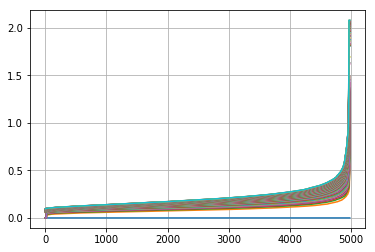

In [64]:
distance = np.sort(distance,axis = 0)
plt.plot(distance);
plt.grid()

In [123]:
#Applying the DBSCAN Algo with minPt = 100, eps = 0.25

km3_cluster = DBSCAN(eps=0.35, min_samples=100)
km3_cluster.fit(D3_Train)

DBSCAN(algorithm='auto', eps=0.35, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=None, p=None)

In [124]:
labels = km3_cluster.labels_
X['Clusters_Label'] = labels
X.head(5)

,Cleaned_Text,Clusters_Label
0,really good idea final product outstanding use...,0
1,received shipment could hardly wait try produc...,0
2,mae ploy sweet chili sauce becoming standard c...,0
3,perfect year round meat dish omaha steaks twic...,0
4,five five dogs agree rather munch liver biscot...,0


In [125]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise = list(labels).count(-1)
print("Clusters Formed : " , n_clusters)
print(" Noise :", noise)

Clusters Formed :  1
 Noise : 103


In [133]:
list(labels).count(-1)

103

In [131]:
from sklearn import metrics
silhouette_score = metrics.silhouette_score(D3_Train,labels)
print(silhouette_score)

0.6128844089737054


In [127]:
final_cluster0 = X.loc[X['Clusters_Label'] == 0]
final_cluster1 = X.loc[X['Clusters_Label'] == -1]

In [135]:
final_cluster1.head(5)

,Cleaned_Text,Clusters_Label
70,tasty gluten free option kids loved spicy,-1
127,treats ones year old dog eat loves,-1
195,licorice good taste daughter gluten free diet ...,-1
203,,-1
272,,-1


Word CLoud for Cluster 0 :


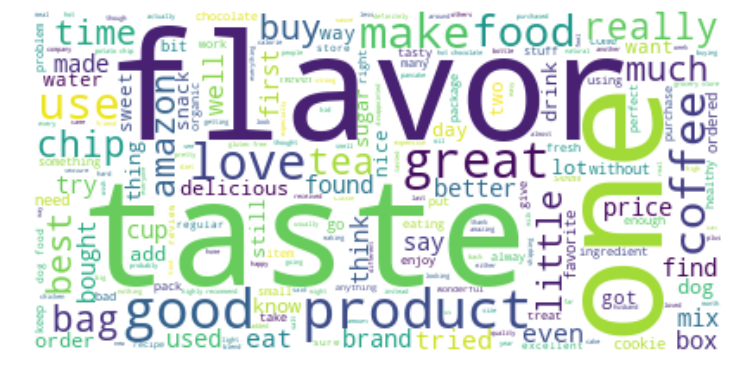

In [129]:
print("Word CLoud for Cluster 0 :")

bow_features = " ".join(final_cluster0['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Summary : 
    This cluster contains words like tea,coffee,flavour,drink etc. It mainly shows beverages. It also shows some products that accompany such bevarges like water,snack etc.

Word CLoud for Noise Cluster (-1) :


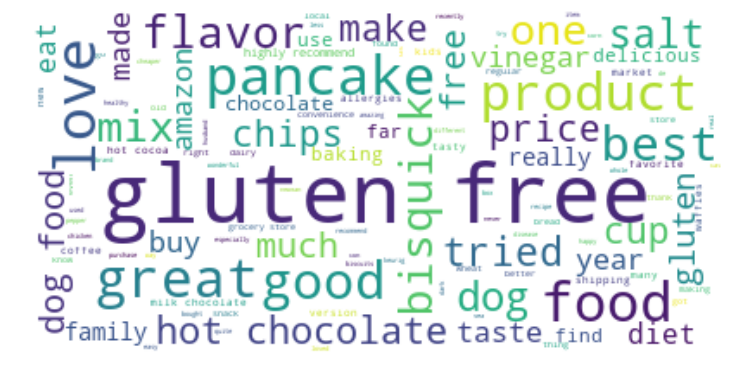

In [130]:
print("Word CLoud for Noise Cluster (-1) :")

bow_features = " ".join(final_cluster1['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Summary :
    This wordcloud contains words of the reviews that are grouped as noise. It contains very different type of products like dog,family,free,salt,free etc.

### 1.2) Applying DBSCAN Clustering on Tf-Idf_Weighted_Word2Vec Text Vectorization

In [90]:
# Splitting the Training Data into sentences
list_of_sentence = []
for sentence in X['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

4986


In [91]:
# Tf-Idf Weighted Word2Vec for Training Data

tf_idf_features = tfidf_vect.get_feature_names()
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

tfidf_w2v_train = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_train.append(sent_vec)
print(len(tfidf_w2v_train))

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:19<00:00, 252.15it/s]


4986


In [92]:
n_train = len(tfidf_w2v_train)
print(n_train)

4986


In [93]:
D4_Train = np.array(tfidf_w2v_train)

In [94]:
# Finding the K Neighbours

minPts = 100
neigh_2 = NearestNeighbors(n_neighbors=minPts)
neigh_2.fit(D4_Train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=100, p=2, radius=1.0)

In [95]:
distance, indices = neigh_2.kneighbors(D4_Train,n_neighbors=minPts)
print(len(distance))
print(type(distance))
print(distance)

4986
<class 'numpy.ndarray'>
[[0.         0.06610967 0.07418418 ... 0.13080613 0.13107    0.13107578]
 [0.         0.05676814 0.05720163 ... 0.12105456 0.121315   0.12153195]
 [0.         0.08591387 0.091096   ... 0.174623   0.1757553  0.17585188]
 ...
 [0.         0.05872407 0.07119784 ... 0.1954552  0.19554066 0.19581248]
 [0.         0.13656262 0.14085932 ... 0.46197792 0.46675087 0.4780954 ]
 [0.         0.11060482 0.11193716 ... 0.19008645 0.19015523 0.19023321]]


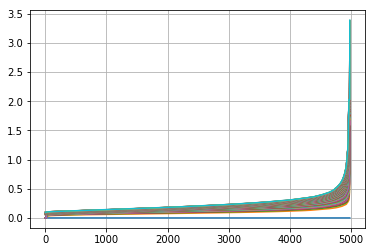

In [96]:
distance = np.sort(distance,axis = 0)
plt.plot(distance);
plt.grid()

In [116]:
#Applying the DBSCAN Algo with minPt = 100, eps = 0.25

km4_cluster = DBSCAN(eps=0.35, min_samples=100)
km4_cluster.fit(D4_Train)

DBSCAN(algorithm='auto', eps=0.35, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=None, p=None)

In [117]:
labels = km4_cluster.labels_
X['Clusters_Label'] = labels
X.head(5)

,Cleaned_Text,Clusters_Label
0,really good idea final product outstanding use...,0
1,received shipment could hardly wait try produc...,0
2,mae ploy sweet chili sauce becoming standard c...,0
3,perfect year round meat dish omaha steaks twic...,0
4,five five dogs agree rather munch liver biscot...,0


In [118]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise = list(labels).count(-1)
print("Clusters Formed : " , n_clusters)
print(" Noise :", noise)

Clusters Formed :  1
 Noise : 209


In [119]:
from sklearn import metrics
silhouette_score = metrics.silhouette_score(D4_Train,labels)
print(silhouette_score)

0.5845726271464298


Since there is noise in the data, silhouettee score doesnot perform well.

In [120]:
final_cluster1 = X.loc[X['Clusters_Label'] == -1]
final_cluster0 = X.loc[X['Clusters_Label'] == 0]

Word CLoud for Cluster 0 :


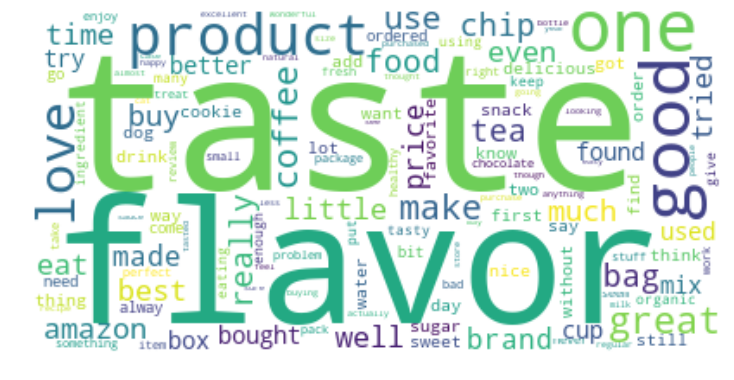

In [121]:
print("Word CLoud for Cluster 0 :")

bow_features = " ".join(final_cluster0['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Summary : 
    This cluster contains words like tea,coffee,flavour,taste etc. It mainly shows beverages. It also shows some products that accompany such bevarges like water,snack,sweet,sugar,cup,cookie etc. It also contains words like great,good,love,better,best,enjoy. These might be an indicator that the reviews in the cluster is mainly positive,which is quite fair as this is highly unbalanced dataset.

Word CLoud for Noise Cluster (-1) :


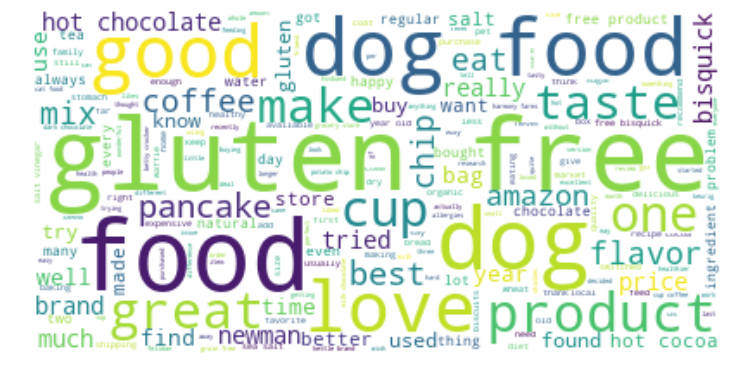

In [122]:
print("Word CLoud for Noise Cluster (-1) :")

bow_features = " ".join(final_cluster1['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpelation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Summary :
    This wordcloud contains words of the reviews that are grouped as noise. It contains very different type of products like dog,family,free,salt,store etc.